In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


# Load the model to attack

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Model Testing


643293/643293 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


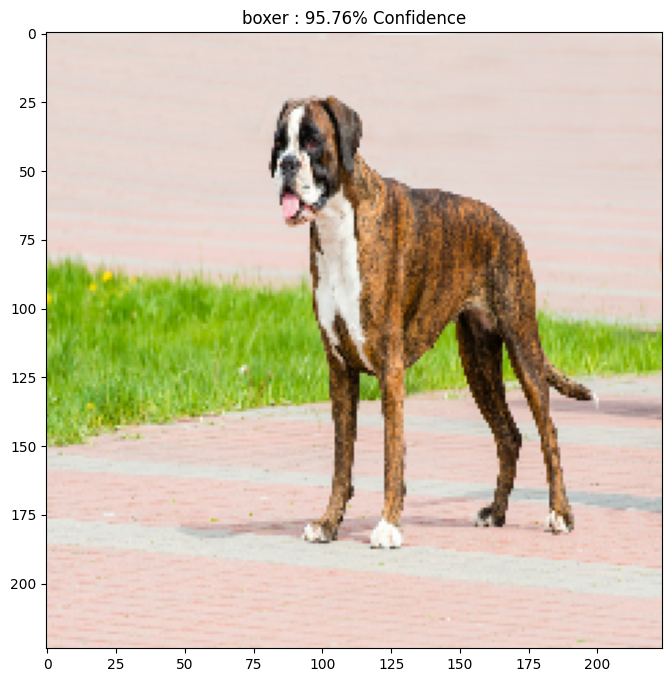

In [3]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

#
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

image_path = tf.keras.utils.get_file('boxer1.jpg', 'https://www.zooplus.fr/magazine/wp-content/uploads/2018/03/deutscher-boxer-tabby.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

# Adversial Attacks

## FGSM

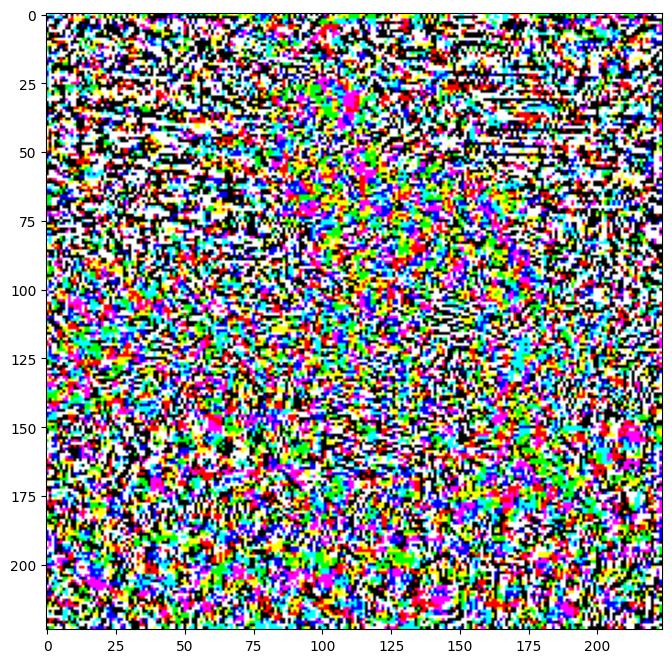

In [4]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)


  gradient = tape.gradient(loss, input_image)

  signed_grad = tf.sign(gradient)
  return signed_grad


boxer_index = 242
label = tf.one_hot(boxer_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


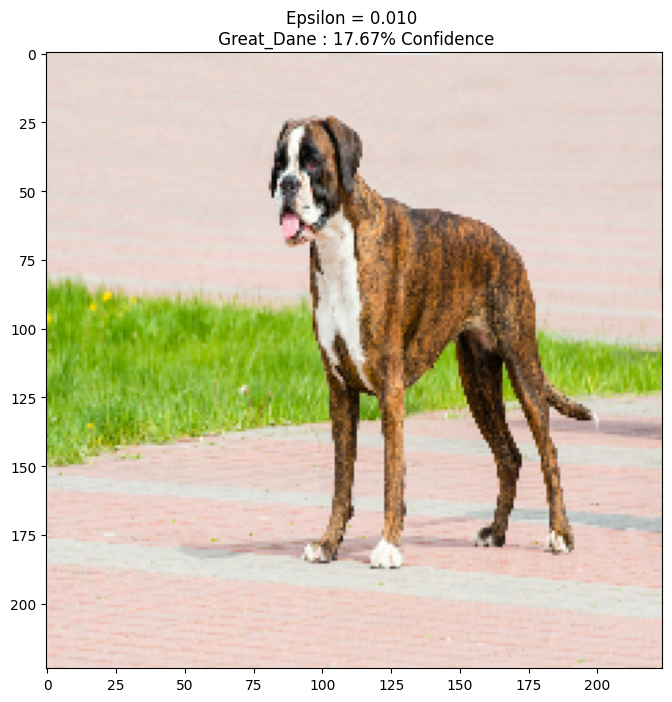

In [5]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

epsilons = [0.01]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

## PGD

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


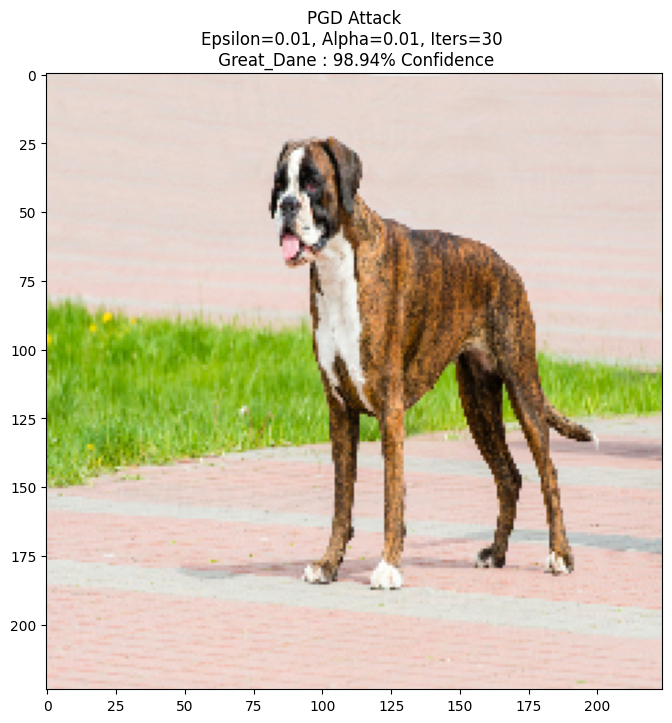

In [9]:
def pgd_attack(model, image, label, eps=0.03, alpha=0.005, iters=40):
    # Initialiser avec l’image d’origine + petite perturbation aléatoire
    adv_image = image + tf.random.uniform(shape=image.shape, minval=-eps, maxval=eps)
    adv_image = tf.clip_by_value(adv_image, -1.0, 1.0)

    for i in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(adv_image)
            loss = loss_object(label, prediction)
        gradient = tape.gradient(loss, adv_image)
        adv_image = adv_image + alpha * tf.sign(gradient)

        # Projection : rester dans l'interval de perturbation autour de l’image originale
        perturbation = tf.clip_by_value(adv_image - image, -eps, eps)
        adv_image = tf.clip_by_value(image + perturbation, -1.0, 1.0)

    return adv_image

eps = 0.01  # maximum perturbation
alpha = 0.01  # step size
iters = 30  # number of iterations

adv_image_pgd = pgd_attack(pretrained_model, image, label, eps=eps, alpha=alpha, iters=iters)
display_images(adv_image_pgd, f'PGD Attack\nEpsilon={eps}, Alpha={alpha}, Iters={iters}')

## FGSM Vs PGD

In [10]:
def display_comparison(original_img, adv_img, model, title1="Original", title2="Adversarial"):
    import matplotlib.pyplot as plt

    def get_label(img):
        preds = model.predict(img)
        decoded = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=1)[0][0]
        label = decoded[1]
        confidence = decoded[2]
        return label, confidence

    label1, conf1 = get_label(original_img)
    label2, conf2 = get_label(adv_img)

    plt.figure(figsize=(10, 4))

    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(original_img[0] * 0.5 + 0.5)  # si normalisée entre [-1, 1]
    plt.title(f"{title1}\n{label1} : {conf1*100:.2f}%")
    plt.axis('off')

    # Image adversariale
    plt.subplot(1, 2, 2)
    plt.imshow(adv_img[0] * 0.5 + 0.5)
    plt.title(f"{title2}\n{label2} : {conf2*100:.2f}%")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


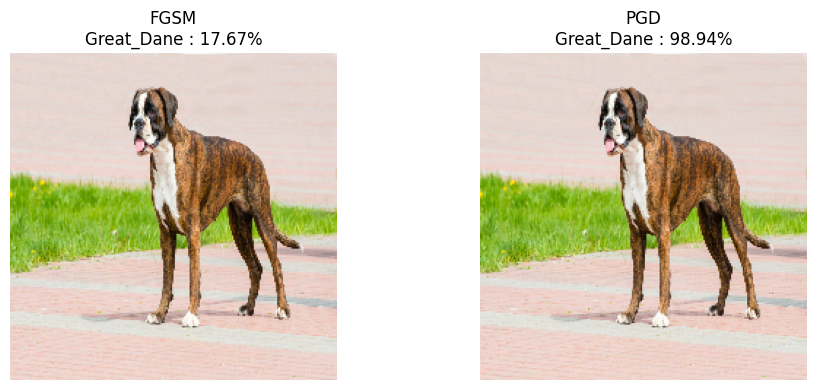

In [11]:
display_comparison(adv_x, adv_image_pgd,pretrained_model, "FGSM", "PGD")